In [207]:
import pandas as pd
import seaborn as sns
import numpy as np

#initial data import
df = pd.read_excel('Data.xlsx')
#want to see all columns
pd.set_option('display.max_columns', None)

### Data Exploration/Tidying

To do:

- ~~Remove individual salary columns~~
- ~~Move total salary between term and employment~~
- Look into employment status columns
- ~~Split up loan purpose column into each type~~
- ~~Add multiple customers indicator column~~
- ~~Application type and industry sector need to be encoded~~
- ~~Can we use age or not?~~
- ~~Can we use nationality? most are irish obviously~~
- ~~Make existing mortgate to salary mandated binary~~
- ~~Make LT 1 year values more useable~~
- ~~Work out what status means~~

In [208]:
#remove last three columns which are empty
df = df.iloc[:,:-3]

In [209]:
#combine salaries of partners
df["Total Salary"] = df.iloc[:,2]+df.iloc[:,3]

In [210]:
#count number of rejects - about half and half (should be fine for not bothering with inference)
#must address the bias issue!!!
(df["Status - G/B/R"]=="R").sum()

6344

In [211]:
#drop separated customer salary columns
df = df.drop(df.columns[2:4],axis=1)

In [212]:
#sanity check, make sure most purposes is 3 (3x3 letters + 2 slash)
max(df["Loan Purpose"].str.len())

#split up each of three purposes into their own column
new = df["Loan Purpose"].str.split("/", n = 2, expand = True)

#replace none with nan
new = new.fillna(value=np.nan)

#add new columns into our data frame corresponding to each distinct purpose
df["Purpose1"] = new[0]
df["Purpose2"] = new[1]
df["Purpose3"] = new[2]

#remove loan purpose column
df = df.drop(["Loan Purpose"],axis=1)

In [213]:
#add new variable for if there are multiple customers (i.e. married couple etc)
df['Multiple Customers'] = np.where(df['Customer2 Age (YYMM)'] == 0 , 0, 1)

In [214]:
df['Single Purpose'] = df["Purpose2"].isnull()*1

In [215]:
#check for any other non-numeric values
df["Time with Bank Years"].unique()

#also need to deal with New as well as LT 1 year

#have a look at 99 years (could be error)

array([10, 14, 6, 3, 13, 15, 11, 8, 17, 4, 9, 2, 5, 16, 20, 'New', 18, 12,
       1, 7, 19, 'LT 1 year', 22, 21, 32, 24, 99, 25, 23, 33, 26, 31, 29,
       27, 28, 30], dtype=object)

In [216]:
#indices of customers with 99 years at bank
error_idx = np.where(df["Time with Bank Years"]==99)

In [217]:
#example of column w 99 years at bank - clearly error so just remove these entries
df.iloc[1097,:]

Application  Date (YYYYMM)                        201002
Term                                                  60
Customer1 Employment Status                            F
Customer2 Emp Status                                 NaN
Application Type                                       S
Industry Sector                                       RS
Customer1 Age (YYMM)                                4405
Customer2 Age (YYMM)                                   0
National of …                                        IRE
CA Months of Unauthorised Debit Interest L6M           1
CA Average Number of Transactions L6M                 10
CA Average Balance L6M                               757
CA Average Credit Turnover L6M                      2510
Existing Mortgage                                      Y
Existing Current Account                               Y
Existing Loan                                        NaN
Existing Savings Acc                                   Y
Salary Mandated to Same Bank Cu

In [218]:
#remove 99 year rows
df = df[df["Time with Bank Years"] != 99]

In [219]:
#replace LT year with 0 years
df.loc[df["Time with Bank Years"]=="LT 1 year","Time with Bank Years"]=0
#replace New with 0 years
df.loc[df["Time with Bank Years"]=="New","Time with Bank Years"]=0
#check all value now numeric
df["Time with Bank Years"].unique()

array([10, 14, 6, 3, 13, 15, 11, 8, 17, 4, 9, 2, 5, 16, 20, 0, 18, 12, 1,
       7, 19, 22, 21, 32, 24, 25, 23, 33, 26, 31, 29, 27, 28, 30],
      dtype=object)

In [221]:
#delete status column - not needed
df = df.drop("Status",axis=1)

In [222]:
nationality_column = df.columns.values.tolist()[8]

#delete nationality column to avoid discrimination
df = df.drop(nationality_column,axis=1)

In [232]:
#remove date column, not necessary
df = df.iloc[:,1:]

In [237]:
#only use accepted applications
df = df[df["Status - G/B/R"] != "R"]

6466

In [262]:
df = pd.DataFrame(df)
df.dtypes

Term                                             int64
Customer1 Employment Status                     object
Customer2 Emp Status                            object
Application Type                                object
Industry Sector                                 object
Customer1 Age (YYMM)                             int64
Customer2 Age (YYMM)                             int64
CA Months of Unauthorised Debit Interest L6M     int64
CA Average Number of Transactions L6M            int64
CA Average Balance L6M                           int64
CA Average Credit Turnover L6M                   int64
Existing Mortgage                               object
Existing Current Account                        object
Existing Loan                                   object
Existing Savings Acc                            object
Salary Mandated to Same Bank Current Account    object
Time with Bank Years                            object
Decision                                        object
Status - G

In [266]:
df["Time with Bank Years"] = pd.to_numeric(df["Time with Bank Years"])

In [267]:
df.dtypes

Term                                             int64
Customer1 Employment Status                     object
Customer2 Emp Status                            object
Application Type                                object
Industry Sector                                 object
Customer1 Age (YYMM)                             int64
Customer2 Age (YYMM)                             int64
CA Months of Unauthorised Debit Interest L6M     int64
CA Average Number of Transactions L6M            int64
CA Average Balance L6M                           int64
CA Average Credit Turnover L6M                   int64
Existing Mortgage                               object
Existing Current Account                        object
Existing Loan                                   object
Existing Savings Acc                            object
Salary Mandated to Same Bank Current Account    object
Time with Bank Years                             int64
Decision                                        object
Status - G

In [272]:
df = df.drop("Decision",axis = 1)

### Random Forest

In [289]:
import sklearn
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble 
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.pipeline import make_pipeline

#dummy variables for categoricals
tree_data = pd.get_dummies(df)


tree_data = tree_data.drop("Status - G/B/R_B",axis="columns")
tree_data = tree_data.drop("Status - G/B/R_G",axis="columns")
tree_data["Outcome"] = df["Status - G/B/R"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tree_data.drop("Outcome",axis = "columns"),tree_data["Outcome"],test_size = 0.2)

In [292]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 20)
model.fit(X_train,y_train)



RandomForestClassifier(n_estimators=20)

In [293]:
model.score(X_test,y_test)

0.9296754250386399

In [294]:
y_pred = model.predict(X_test)

In [295]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test,y_pred)
matrix

array([[   7,   81],
       [  10, 1196]])

In [303]:
list(y_train).count("G")

4765

Text(69.0, 0.5, 'Truth')

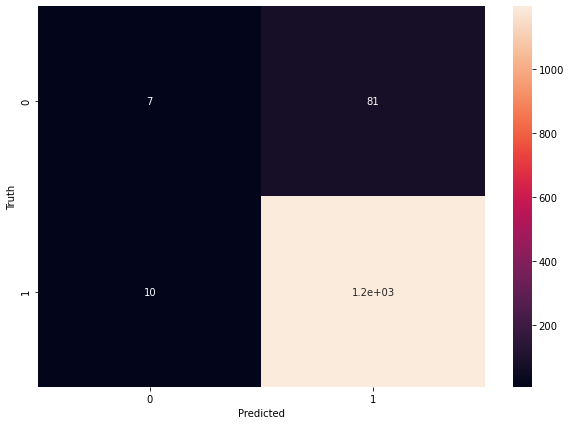

In [305]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
sns.heatmap(matrix,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

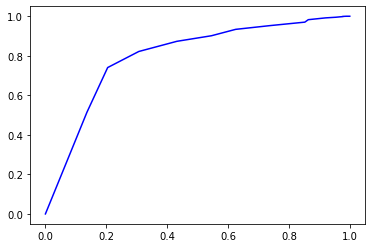

In [308]:
import sklearn.metrics as metrics

probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test,preds,pos_label="G")
roc_auc = metrics.auc(fpr,tpr)

plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % roc_auc)